In [263]:
%run 'init.ipynb'
save = get_figsave(3)

<function __main__.get_figsave.<locals>.save(fig, name)>

## Ecological interpretation

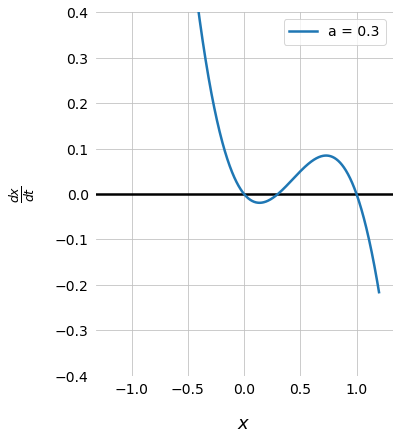

In [2]:
def xdot_1(x, a):
    return x * (1 - x) * (x - a)
    
def plot(ax, a, xlim=1.2, ylim=(-0.4, 0.4)):
    ax.axhline(0, c='black')
    X = np.linspace(-xlim, xlim, 1000)
    ax.plot(X, xdot_1(X, a), label=f'a = {a:g}')
    ax.set_xlabel(r'$x$')
    ax.set_ylabel(r'$\frac{dx}{dt}$')
    ax.set_ylim(ylim)

fig, ax = plt.subplots(figsize=(6,6))
plot(ax, 0.3)
ax.legend();

## y = 0

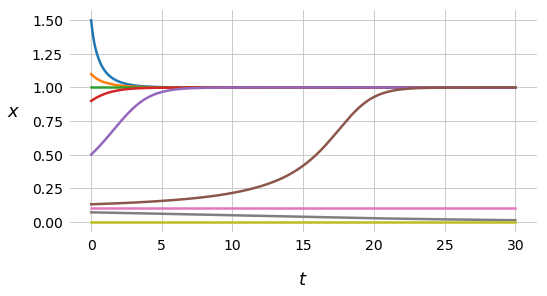

In [3]:
aa = 0.1
bb = 1.5

from scipy.integrate import solve_ivp

def f(t, x):
    return [xdot_1(x, aa)]
    
def plot_sim(ax, x_0=0.8):
    t_span = (0.01, 30)
    t_eval = np.logspace(*np.log10(t_span), 1000)
    sol = solve_ivp(f, (t_eval[0], t_eval[-1]), [x_0], t_eval=t_eval)
    ax.plot(sol.t, sol.y.flatten(), label=f'$x_0 = {x_0}$')

fig, ax = plt.subplots(figsize=(8,4))
for x_0 in reversed([0, 0.07, 0.1, 0.13, 0.5, 0.9, 1, 1.1, 1.5]):
    plot_sim(ax, x_0)

ax.set_xlabel('$t$')
ax.set_ylabel('$x$', rotation=0);
# ax.legend();
save(fig, 'time_sim')

## Fixed points

In [570]:
x,y,a,b,c,d = sp.symbols('x,y,a,b,c,d')

def get_subs(cc=1):
     return dict(a=aa, b=bb, c=cc)

def evaluate(expr, cc=1):
    return expr.subs(get_subs(cc=cc))

xdot_full = x * (x - a) * (1 - x) - b*x*y
ydot_full = x*y - c*y - d

xdot = xdot_full
ydot = ydot_full.subs(d, 0)

F = sp.Matrix([xdot, ydot])
J = F.jacobian([x, y])

fp = sp.solve(F, {x,y})

In [5]:
J0 = J.subs(fp[0])
J0.det(), J0.trace()

In [6]:
J0.eigenvects(simplify=True)

⎡⎛       ⎡⎡1⎤⎤⎞  ⎛       ⎡⎡0⎤⎤⎞⎤
⎢⎜-a, 1, ⎢⎢ ⎥⎥⎟, ⎜-c, 1, ⎢⎢ ⎥⎥⎟⎥
⎣⎝       ⎣⎣0⎦⎦⎠  ⎝       ⎣⎣1⎦⎦⎠⎦

In [7]:
J1 = J.subs(fp[1])
J1.det(), J1.trace()

In [8]:
J1.eigenvects(simplify=True)

⎡                   ⎛           ⎡⎡    b    ⎤⎤⎞⎤
⎢⎛          ⎡⎡1⎤⎤⎞  ⎜           ⎢⎢─────────⎥⎥⎟⎥
⎢⎜a - 1, 1, ⎢⎢ ⎥⎥⎟, ⎜-c + 1, 1, ⎢⎢a + c - 2⎥⎥⎟⎥
⎢⎝          ⎣⎣0⎦⎦⎠  ⎜           ⎢⎢         ⎥⎥⎟⎥
⎣                   ⎝           ⎣⎣    1    ⎦⎦⎠⎦

In [9]:
J2 = J.subs(fp[2])
J2.det(), J2.trace()

In [10]:
J2.eigenvects(simplify=True)

⎡⎛          ⎡⎡-a⋅b  ⎤⎤⎞                      ⎤
⎢⎜          ⎢⎢──────⎥⎥⎟                      ⎥
⎢⎜          ⎢⎢ 2    ⎥⎥⎟  ⎛   2         ⎡⎡1⎤⎤⎞⎥
⎢⎜a - c, 1, ⎢⎢a  - c⎥⎥⎟, ⎜- a  + a, 1, ⎢⎢ ⎥⎥⎟⎥
⎢⎜          ⎢⎢      ⎥⎥⎟  ⎝             ⎣⎣0⎦⎦⎠⎥
⎣⎝          ⎣⎣  1   ⎦⎦⎠                      ⎦

In [11]:
J3 = J.subs(fp[3])
J3.det(), sp.simplify(J3.trace())

In [15]:
J3.eigenvects(simplify=True)

⎡⎛                     ______________________________________________     ⎡⎡  
⎢⎜                    ╱   ⎛ 2          2                    3      ⎞      ⎢⎢──
⎢⎜c⋅(a - 2⋅c + 1)   ╲╱  c⋅⎝a ⋅c - 4⋅a⋅c  - 2⋅a⋅c + 4⋅a + 4⋅c  - 3⋅c⎠      ⎢⎢  
⎢⎜─────────────── - ─────────────────────────────────────────────────, 1, ⎢⎢  
⎢⎜       2                                  2                             ⎢⎢a⋅
⎢⎜                                                                        ⎢⎢  
⎣⎝                                                                        ⎣⎣  

                            2⋅b⋅c                               ⎤⎤⎞  ⎛        
────────────────────────────────────────────────────────────────⎥⎥⎟  ⎜        
                  ______________________________________________⎥⎥⎟  ⎜c⋅(a - 2
       2         ╱   ⎛ 2          2                    3      ⎞ ⎥⎥⎟, ⎜────────
c - 2⋅c  + c + ╲╱  c⋅⎝a ⋅c - 4⋅a⋅c  - 2⋅a⋅c + 4⋅a + 4⋅c  - 3⋅c⎠ ⎥⎥⎟  ⎜       2
                                                   

In [12]:
A = J3.evalf(subs=get_subs())
AA = np.array(A).astype(np.float).round(2)

array([[-0.9, -1.5],
       [-0, 0]])

## fp 3 eig

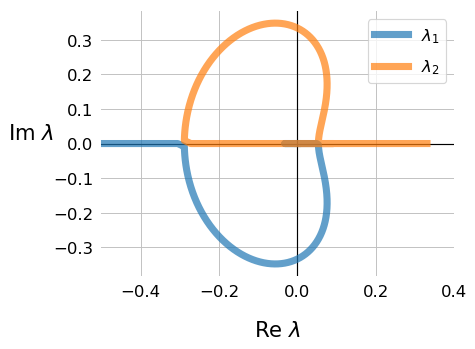

In [807]:
ev = list(J3.eigenvals().keys())
ev0_np = sp.lambdify((c,), ev[0].subs(dict(a=aa, b=bb)))
ev1_np = sp.lambdify((c,), ev[1].subs(dict(a=aa, b=bb)))

cs = np.linspace(0.0, 1.5, 5000)
lambda_1 = ev0_np(cs+0j)
lambda_2 = ev1_np(cs+0j)

fig, ax = plt.subplots()
ax.axvline(color='black', lw=1)
ax.axhline(color='black', lw=1)
ax.plot(lambda_1.real, lambda_1.imag, '-', alpha=0.7, label='$\lambda_1$', lw=6)
ax.plot(lambda_2.real, lambda_2.imag, '-', alpha=0.7, label='$\lambda_2$', lw=6)
ax.set_xlabel(r'Re $\lambda$');
ax.set_ylabel(r'Im $\lambda$', rotation=0)
ax.set_xlim(-0.5, 0.4)
ax.legend()
save(fig, 'eigenheart')

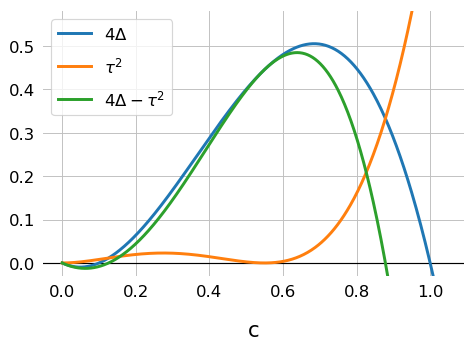

In [305]:
det = J3.det()
tr = sp.simplify(J3.trace())

# spiral = sp.lambdify(c, (4*det - tr**2).subs(a, aa))
det_np = sp.lambdify(c, det.subs(a, aa))
tr_np = sp.lambdify(c, tr.subs(a, aa))

cs = np.linspace(0, 1.04, 600)
fig, ax = plt.subplots()
ax.axhline(color='black', lw=1)
ax.plot(cs, 4*det_np(cs), label=r'$4 \Delta$')
ax.plot(cs, tr_np(cs)**2, label=r'$\tau^2$')
ax.plot(cs, 4*det_np(cs) - tr_np(cs)**2, label=r'$4 \Delta - \tau^2$')
ax.set_xlabel('c')
ax.legend();
ax.set_ylim(-0.03, 0.58)
save(fig, 'delta_tau');

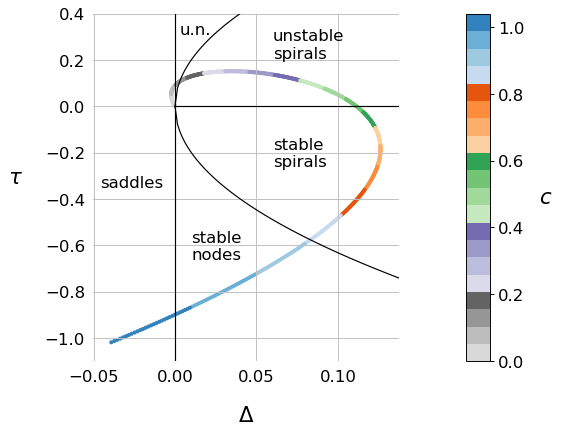

In [306]:
cs = np.linspace(0, 1.04, 600)

fig, ax = plt.subplots(figsize=(7,5))
ax.axvline(color='black', lw=1)
scatter = ax.scatter(det_np(cs), tr_np(cs), s=6, c=cs, cmap=mpl.cm.tab20c_r)
cbar = fig.colorbar(scatter)
cbar.ax.set_ylabel('$c$', rotation=0)
xlim = ax.get_xlim()
ylim = ax.get_ylim()
ax.hlines(0, 0, 1, color='black', lw=1)
delta = np.linspace(0, 0.15, 100)
ax.plot(delta, +2*np.sqrt(delta), c='k', lw=1)
ax.plot(delta, -2*np.sqrt(delta), c='k', lw=1)
ax.set_xlim(xlim)
ax.set_ylim(ylim)
ax.set_ylim(-1.1, 0.4)
ax.set_xlabel(r'$\Delta$');
ax.set_ylabel(r'$\tau$', rotation=0, ha='right')
ax.text(-0.046, -0.35, 'saddles', fontsize=14)
ax.text(+0.01, -0.66, 'stable\nnodes', fontsize=14)
ax.text(+0.06, -0.26, 'stable\nspirals', fontsize=14)
ax.text(+0.06, +0.21, 'unstable\nspirals', fontsize=14)
ax.text(+0.003, +0.31, 'u.n.', fontsize=14)
save(fig, 'stability_diagram')

## fp 3 intersections

In [216]:
set_np_precision(5)

In [217]:
from scipy.optimize import root
parabola = lambda c: 4*det_np(c) - tr_np(c)**2

root(det_np, x0=0.2).x

array([0.1])

In [244]:
c_u = root(parabola, x0=0.2).x

array([0.12591])

In [219]:
root(tr_np, x0=0.6).x

array([0.55])

In [245]:
c_s = root(parabola, x0=0.8).x

array([0.87834])

In [220]:
root(det_np, x0=1).x

array([1])

And now symbolically

In [226]:
sp.solve(det, c)

In [227]:
sp.solve(tr, c)

In [230]:
# sp.solve(4*det - tr**2, c)
# Too complex expression

## fp 3 path

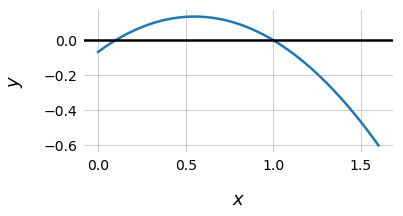

In [14]:
root_x = sp.lambdify(c, fp[3][x].subs(dict(a=aa, b=bb)))
root_y = sp.lambdify(c, fp[3][y].subs(dict(a=aa, b=bb)))

cs = np.linspace(0, 1.6)

fig, ax = plt.subplots()
ax.plot(root_x(cs), root_y(cs))
ax.axhline(c='black')
ax.set_xlabel('$x$')
ax.set_ylabel('$y$')
ax.set_aspect('equal');

## Phase space

In [563]:
c_heterocline = 0.44597197

In [813]:
from scipy.spatial.distance import pdist, squareform

def eval_fp(c):
    return [[p[coord].evalf(2, subs=get_subs(c)) for coord in (x,y)] for p in fp]


def get_grid(cc):
    x_grid, y_grid = np.meshgrid(np.linspace(0, 1.10, 200),
                                 np.linspace(0, 0.61, 200),
                                )
    xdot_np = sp.lambdify((x,y), xdot.subs(get_subs(cc=cc)))
    ydot_np = sp.lambdify((x,y), ydot.subs(get_subs(cc=cc)))

    xdot_grid = xdot_np(x_grid, y_grid)
    ydot_grid = ydot_np(x_grid, y_grid)
    
    return x_grid, y_grid, xdot_grid, ydot_grid


def sim2(cc=0.4, x0=0.4, y0=0.02, fwd=True, t_span=(0.001,300), N_eval=1000):
    xdot_np = sp.lambdify((x,y), xdot.subs(get_subs(cc=cc)))
    ydot_np = sp.lambdify((x,y), ydot.subs(get_subs(cc=cc)))

    def f(t, y):
        return [xdot_np(y[0], y[1]), ydot_np(y[0], y[1])]

    t_span = np.array(t_span)
    # t_eval = np.linspace(*t_span, N_eval)
    t_eval = np.logspace(*np.log10(t_span), N_eval)
    if not fwd:
        t_span = -t_span
        t_eval = -t_eval
    t_span_arg = (t_eval[0], t_eval[-1])
    sol = solve_ivp(f, t_span_arg, [x0, y0], t_eval=t_eval)
    return sol.t, sol.y[0,:], sol.y[1,:]


def get_unstable_inits(cc, fp_num, eps=1e-2):
    inits = []
    fp_i = fp[fp_num]
    fp_x = evaluate(fp_i[x], cc)
    fp_y = evaluate(fp_i[y], cc)
    J_i = evaluate(J.subs(fp_i), cc)
    if J_i.det() >= 0:
        print(f'fp {fp_num} is not a saddle for c={cc}')
        return None
    for (evall, _, evecs) in J_i.eigenvects():
        if sp.re(evall) < 0:
            evec = evecs[0]
            return (
                sp.Matrix([fp_x, fp_y]) + eps * evec,
                sp.Matrix([fp_x, fp_y]) - eps * evec,
            )


def get_closed_orbit(cc, x0=1, y0=0.05, max_distance=0.0004, min_duration=4, N_eval=5000, t_span=(0.001,300)):
    t, xx, yy = sim2(cc, x0, y0, fwd=True, t_span=t_span, N_eval=N_eval)
    
    xy = np.stack([xx, yy], axis=1)
    tt = np.stack([t, t], axis=1)

    spatial_dist = pdist(xy)
    time_dist = pdist(tt)

    close_enough_in_space = spatial_dist < max_distance
    far_enough_in_time = time_dist > min_duration
    valid_ix_condensed = np.logical_and(close_enough_in_space, far_enough_in_time)
    num_valid = np.sum(valid_ix_condensed)
    if num_valid == 0:
        print(f'No trajectories found matching (max_dist={max_distance:.3g}, min_dur={min_duration:.3g})')

    valid_ix = np.nonzero(squareform(valid_ix_condensed))
    # selected_ix = num_valid//2
    selected_ix = -1
    ix_0 = valid_ix[0][selected_ix]
    ix_f = valid_ix[1][selected_ix]
    if ix_0 > ix_f:
        ix_0, ix_f = ix_f, ix_0

    period = t[ix_f] - t[ix_0]
    x_orbit = xx[ix_0:ix_f]
    y_orbit = yy[ix_0:ix_f]
    
    # Close circle
    x_orbit = np.concatenate([x_orbit, [x_orbit[0]]])
    y_orbit = np.concatenate([y_orbit, [y_orbit[0]]])
    
    return period, x_orbit, y_orbit

184.36670122127714


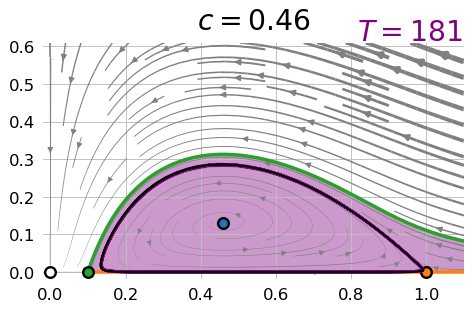

In [814]:
def plot_grid(cc):
    grid = get_grid(cc)
    fig, ax = streamplot(*grid, speed=1, lw_0=0.2, figsize=(6,4), color='grey')
    xlim = ax.get_xlim()
    ylim = ax.get_ylim()
    fp_colors = ('white', 'C1', 'C2', 'C0')
    lc_color = 'purple'
    x_sep = None
    y_sep = None
    
    # Separatrices
    for fp_num in reversed((1,2)):
        inits = get_unstable_inits(cc, fp_num)
        if inits is not None:
            for x0, y0 in inits:
                if (x0 >= 0) and (y0 >= 0):
                    _, x, y = sim2(cc=cc, x0=x0, y0=y0, fwd=False)
                    ax.plot(x, y, lw=3, color=fp_colors[fp_num])
                    if fp_num == 2:
                        x_sep, y_sep = x, y

    # FP dots
    for (x, y), color in zip(eval_fp(cc), fp_colors):
        ax.plot(x, y, '.', ms=18, c=color, markeredgewidth=2, markeredgecolor='k')
    
    # Limit cycle
    if c_heterocline < cc < 0.55:
        period, x_orbit, y_orbit = get_closed_orbit(cc)
        fig.text(0.94, 0.91, f'$T = {float(period):.0f}$', fontsize=24, color='purple', ha='right', va='top')
        ax.plot(x_orbit, y_orbit, color=lc_color)
    
    # Basin of attraction
    if cc > 1:
        ax.fill_between(x_sep, y1=y_sep, y2=0, alpha=0.4, color=fp_colors[1])
    elif cc >= 0.55:
        ax.fill_between(x_sep, y1=y_sep, y2=0, alpha=0.4, color=fp_colors[3])
    elif cc >= c_heterocline:
        ax.fill_between(x_sep, y1=y_sep, y2=0, alpha=0.4, color=lc_color)
    
    ax.set_xlim(-0.019, xlim[-1])
    ax.set_ylim(-0.019, ylim[-1])
    # ax.set_xlabel('$x$')
    # ax.set_ylabel('$y$', rotation=0, ha='right')
    ax.set_title(f'$c = {float(cc):.6g}$', pad=11, fontsize=24)
    return fig, ax


def plot_traj(ax, cc, x0, y0):
    _, xx, yy = sim2(cc, x0, y0, fwd=True, t_span=(0.01, 300), N_eval=4000)
    ax.plot(x0, y0, '.', color='black')
    ax.plot(xx, yy, color='black', lw=1)


def phase_filename(cc):
    cc = float(cc)
    return f'phase_space_{cc:.4f}'.replace('.','')


cc = 0.46
fig, ax = plot_grid(cc=cc)
# plot_traj(ax, cc, 0.6, 0.1)
period, x_orbit, y_orbit = get_closed_orbit(cc, 0.6, 0.1)
ax.plot(x_orbit, y_orbit, color='black', lw=1)
print(period)

In [776]:
c_heterocline

In [777]:
cs = (
    0,
    0.05,
    0.1,
    0.114,
    c_u,
    0.3,
    0.43,
    c_heterocline,
    # 0.447, # incorrect period
    # 0.448, # incorrect period
    # 0.449, # incorrect period
    # 0.450, # incorrect period
    # 0.46, # incorrect period
    0.47, # correct period ?
    0.53,
    0.5499,
    0.55,
    0.7,
    c_s,
    0.92,
    1,
    1.1,
)

for cc in cs:
    fig, ax = plot_grid(cc)
    save(fig, phase_filename(cc))
    plt.close()

fp 2 is not a saddle for c=0
fp 2 is not a saddle for c=0.05
fp 2 is not a saddle for c=0.1
fp 1 is not a saddle for c=1
fp 1 is not a saddle for c=1.1


## .

## Simulations

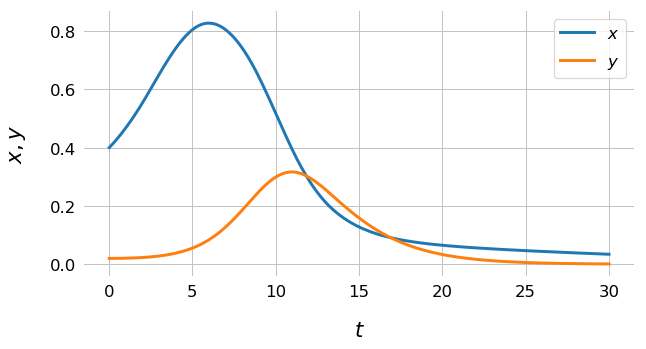

In [283]:
def plot_sim2(**kwargs):
    t, x, y = sim2(**kwargs)
    fig, ax = plt.subplots(figsize=(8,4))
    ax.plot(t, x, label='$x$')
    ax.plot(t, y, label='$y$')
    ax.set_xlabel('$t$')
    ax.set_ylabel('$x, y$', rotation=90);
    ax.legend()
    return fig, ax

fig, ax = plot_sim2();
# save(fig, 'xy_time_sim')

## Coco ik

In [25]:
xdot_full_filled = xdot_full.subs(dict(a=aa, b=bb))
ydot_full_filled = ydot_full.subs(dict(a=aa, b=bb))

F_full = sp.Matrix([xdot_full_filled, ydot_full_filled])

⎡-1.5⋅x⋅y + x⋅(-x + 1)⋅(x - 0.1)⎤
⎢                               ⎥
⎣        -c⋅y - d + x⋅y         ⎦

In [26]:
J_full = F_full.jacobian([x, y])

⎡x⋅(-x + 1) - x⋅(x - 0.1) - 1.5⋅y + (-x + 1)⋅(x - 0.1)  -1.5⋅x⎤
⎢                                                             ⎥
⎣                          y                            -c + x⎦

For a given $c$, we want to know where the fixed points are, i.e. (x,y) solution(s).

In [27]:
# sp.solve({xdot_full, ydot_full}, {x, y})
# Nope, alas

from scipy.optimize import root

F_full_np = sp.lambdify((x,y,c,d), F_full)
J_full_np = sp.lambdify((x,y,c,d), J_full)

f = lambda x, c, d: F_full_np(x[0], x[1], c, d).astype(float).flatten()
JJ = lambda x, c, d: J_full_np(x[0], x[1], c, d).astype(float)


def plot_bifurc(dd=0, x_span = (-1.1, 1.1), c_span = (-1.5, 1.5)):
    c_space = np.linspace(*c_span, 100)
#     guess = [0.4, 0.12]
    guess_x, guess_y = np.meshgrid(np.linspace(0, 1.1, 20),
                                   np.linspace(0, 0.15, 20),
                                  )
#     fp = np.zeros((c_space.size, 2))
    fp = []

    for i, cc in enumerate(c_space):
        for j in range(guess_x.shape[0]):
            for k in range(guess_y.shape[0]):
                guess = [guess_x[j,k], guess_y[j,k]]
                rota = root(f, x0=guess, args=(cc,dd), jac=JJ).x
                fp.append(rota)
                # guess = fp[i,:]

#     fig, (left, right) = plt.subplots(ncols=2, figsize=(9,5))
#     left.plot(fp[:,0], c_space, 'C2.', lw=2, ms=6)
#     right.plot(fp[:,1], c_space, 'C2.', lw=2, ms=6)
#     left.set_xlabel('$x$')
#     left.set_ylabel('$c$')
#     right.set_xlabel('$y$')
#     right.set_ylabel('$c$')
#     return fig, (left, right)
    return fp

fp_list = plot_bifurc();

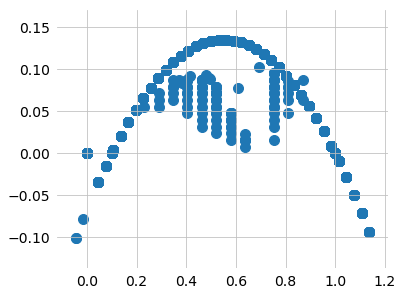

In [28]:
fp_mash = np.stack(fp_list)
plt.scatter(fp_mash[:,0], fp_mash[:,1])

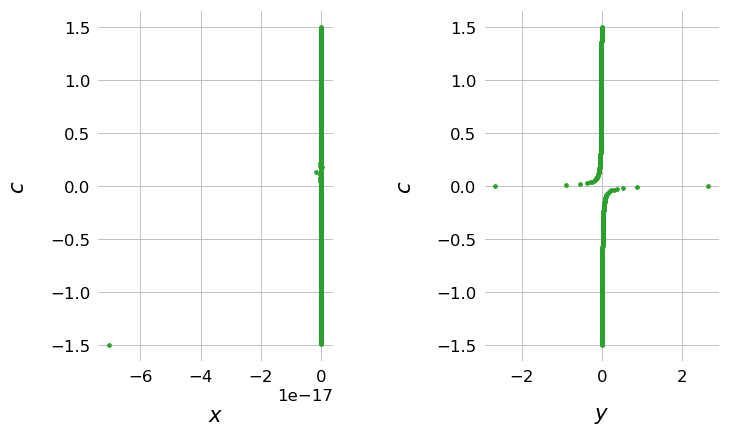

In [320]:
plot_bifurc(0.01);

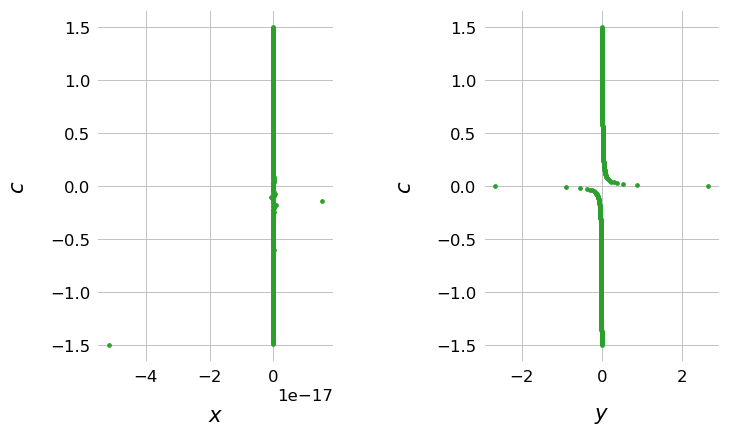

In [321]:
plot_bifurc(-0.01);